In [1]:
!pip install kagglehub torch torchvision pandas numpy matplotlib seaborn scikit-learn pillow tqdm -q
print("✅ All packages installed successfully!")

✅ All packages installed successfully!


In [2]:
"""
Import all necessary libraries and set up the environment
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, datasets
from PIL import Image
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {device}")
if device.type == 'cuda':
    print(f"   GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


🖥️  Using device: cuda
   GPU Name: Tesla T4
   GPU Memory: 15.83 GB


In [3]:
"""
EMNIST (Extended MNIST) contains:
- Digits: 0-9
- Letters: A-Z (uppercase)
We'll use EMNIST-ByClass split which has 62 classes total
We'll select only digits (0-9) and uppercase letters (A-Z) = 36 classes
"""
print("="*80)
print("📂 LOADING EMNIST DATASET (Digits + Letters)")
print("="*80)

# Download EMNIST dataset
print("\n📥 Downloading EMNIST dataset (this may take a few minutes)...")

# Transform to apply
# IMPORTANT: EMNIST images need to be rotated and flipped to display correctly
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.rot90(x, k=3, dims=[1, 2])),  # Rotate 270 degrees
    transforms.Lambda(lambda x: torch.flip(x, dims=[2])),  # Flip horizontally
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load EMNIST ByClass
from torchvision.datasets import EMNIST

train_dataset_full = EMNIST(root='./data', split='byclass', train=True,
                             download=True, transform=transform)
test_dataset_full = EMNIST(root='./data', split='byclass', train=False,
                            download=True, transform=transform)

print(f"✅ Downloaded EMNIST dataset")
print(f"   Total train samples: {len(train_dataset_full)}")
print(f"   Total test samples: {len(test_dataset_full)}")

# EMNIST ByClass has 62 classes:
# 0-9: digits (classes 0-9)
# 10-35: uppercase letters A-Z (classes 10-35)
# 36-61: lowercase letters a-z (we'll skip these)

print("\n🔍 Filtering to keep only digits (0-9) and uppercase letters (A-Z)...")

def filter_dataset(dataset, keep_classes=range(36)):
    """Filter dataset to keep only specified classes (0-35 for digits + uppercase)"""
    indices = [i for i, (_, label) in enumerate(dataset) if label in keep_classes]
    return torch.utils.data.Subset(dataset, indices)

# Filter both train and test sets
train_dataset = filter_dataset(train_dataset_full)
test_dataset = filter_dataset(test_dataset_full)

print(f"✅ Filtered dataset:")
print(f"   Train samples: {len(train_dataset)}")
print(f"   Test samples: {len(test_dataset)}")
print(f"   Classes: 0-9 (digits) + A-Z (letters) = 36 classes")

# Create class names
class_names = [str(i) for i in range(10)] + [chr(65+i) for i in range(26)]
print(f"\n🏷️  Class Labels: {class_names}")

📂 LOADING EMNIST DATASET (Digits + Letters)

📥 Downloading EMNIST dataset (this may take a few minutes)...


100%|██████████| 562M/562M [00:06<00:00, 82.7MB/s]


✅ Downloaded EMNIST dataset
   Total train samples: 697932
   Total test samples: 116323

🔍 Filtering to keep only digits (0-9) and uppercase letters (A-Z)...
✅ Filtered dataset:
   Train samples: 533993
   Test samples: 89264
   Classes: 0-9 (digits) + A-Z (letters) = 36 classes

🏷️  Class Labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']



🎯 CREATING DATALOADERS
✅ DataLoaders created:
   Batch size: 128
   Train batches: 4172
   Test batches: 698

📸 Sample images from dataset:


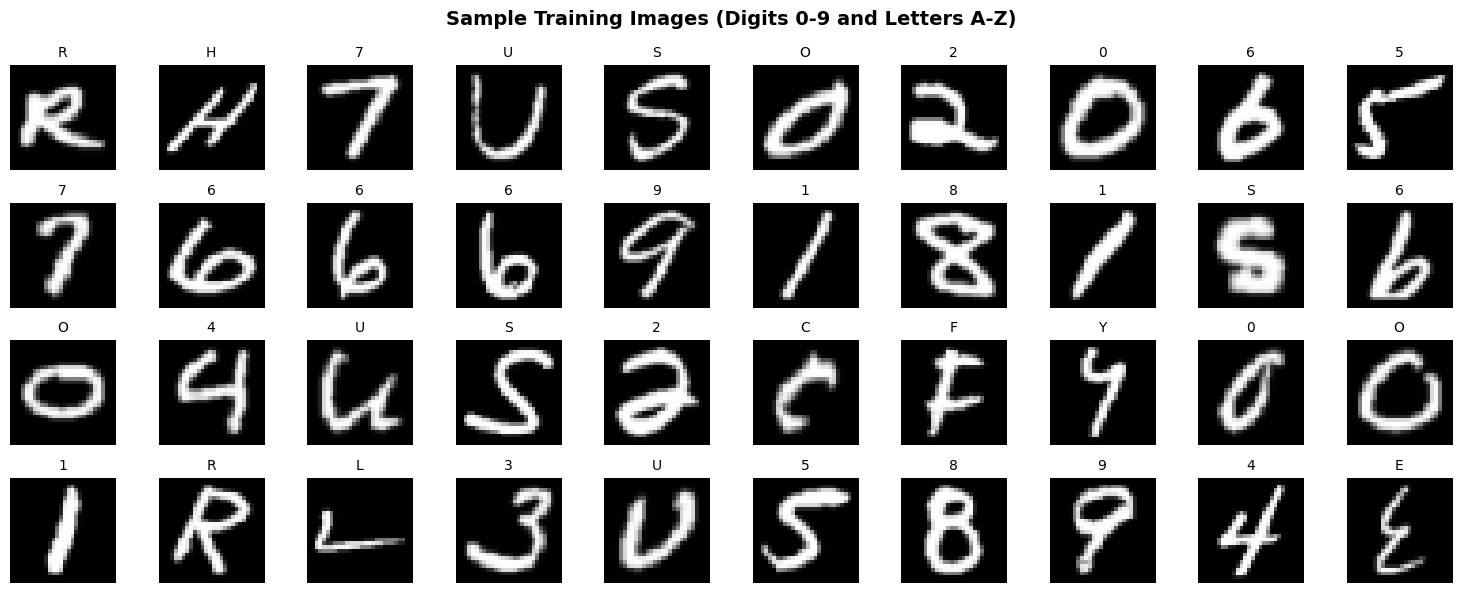

In [4]:
print("\n" + "="*80)
print("🎯 CREATING DATALOADERS")
print("="*80)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"✅ DataLoaders created:")
print(f"   Batch size: {batch_size}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Test batches: {len(test_loader)}")

# Visualize samples
print("\n📸 Sample images from dataset:")
fig, axes = plt.subplots(4, 10, figsize=(15, 6))
axes = axes.ravel()

# Get random samples
sample_indices = np.random.choice(len(train_dataset), 40, replace=False)
for i, idx in enumerate(sample_indices):
    img, label = train_dataset[idx]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f'{class_names[label]}', fontsize=10)
    axes[i].axis('off')

plt.suptitle('Sample Training Images (Digits 0-9 and Letters A-Z)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [5]:
print("\n" + "="*80)
print("🏗️  BUILDING CNN MODEL")
print("="*80)

class ImprovedCNN(nn.Module):
    """
    Improved CNN for 36-class character recognition

    Architecture:
    - 3 Convolutional blocks with BatchNorm and Dropout
    - Max pooling for dimension reduction
    - 3 Fully connected layers
    - Designed to achieve 85%+ accuracy
    """
    def __init__(self, num_classes=36):
        super(ImprovedCNN, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)

        # Convolutional Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)

        # Convolutional Block 3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.25)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.bn7 = nn.BatchNorm1d(256)
        self.dropout4 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 128)
        self.bn8 = nn.BatchNorm1d(128)
        self.dropout5 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully Connected
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = F.relu(self.bn8(self.fc2(x)))
        x = self.dropout5(x)
        x = self.fc3(x)

        return x

# Initialize model
model = ImprovedCNN(num_classes=36).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Model created successfully!")
print(f"📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")


🏗️  BUILDING CNN MODEL
✅ Model created successfully!
📊 Total parameters: 620,804
📊 Trainable parameters: 620,804


In [6]:
print("\n" + "="*80)
print("⚙️  SETTING UP TRAINING")
print("="*80)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.parameters(),
    lr=0.001,
    weight_decay=1e-5
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

print("✅ Loss Function: CrossEntropyLoss")
print("✅ Optimizer: Adam (lr=0.001)")
print("✅ Scheduler: ReduceLROnPlateau")



⚙️  SETTING UP TRAINING
✅ Loss Function: CrossEntropyLoss
✅ Optimizer: Adam (lr=0.001)
✅ Scheduler: ReduceLROnPlateau


In [7]:
current_lr = optimizer.param_groups[0]['lr']
print(f"🔁 Current Learning Rate: {current_lr:.6f}")


🔁 Current Learning Rate: 0.001000


In [8]:
print("\n" + "="*80)
print("🚀 TRAINING THE MODEL")
print("="*80)

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(loader, desc="Training", leave=False)
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Validation", leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


🚀 TRAINING THE MODEL


In [9]:
# Training parameters
num_epochs = 30
best_val_acc = 0.0
patience = 7
patience_counter = 0

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print(f"🎯 Training for up to {num_epochs} epochs...")
print(f"⏱️  Early stopping patience: {patience}\n")

for epoch in range(num_epochs):
    print(f"📍 Epoch {epoch+1}/{num_epochs}")
    print("-" * 80)

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, test_loader, criterion, device)

    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, 'best_model.pth')
        print(f"✅ Best model saved! (Val Acc: {best_val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"⏳ Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"\n⏹️  Early stopping triggered!")
            break
    print()

print(f"{'='*80}")
print(f"✅ TRAINING COMPLETED!")
print(f"🏆 Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"{'='*80}")

# Load best model
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

🎯 Training for up to 30 epochs...
⏱️  Early stopping patience: 7

📍 Epoch 1/30
--------------------------------------------------------------------------------


Train Loss: 0.3902 | Train Acc: 87.35%
Val Loss:   0.1868 | Val Acc:   92.68%
✅ Best model saved! (Val Acc: 92.68%)

📍 Epoch 2/30
--------------------------------------------------------------------------------


Train Loss: 0.2374 | Train Acc: 91.53%
Val Loss:   0.1725 | Val Acc:   93.28%
✅ Best model saved! (Val Acc: 93.28%)

📍 Epoch 3/30
--------------------------------------------------------------------------------


Train Loss: 0.2181 | Train Acc: 92.14%
Val Loss:   0.1666 | Val Acc:   93.52%
✅ Best model saved! (Val Acc: 93.52%)

📍 Epoch 4/30
--------------------------------------------------------------------------------


Train Loss: 0.2088 | Train Acc: 92.47%
Val Loss:   0.1623 | Val Acc:   93.63%
✅ Best model saved! (Val Acc: 93.63%)

📍 Epoch 5/30
--------------------------------------------------------------------------------


Train Loss: 0.2025 | Train Acc: 92.66%
Val Loss:   0.1630 | Val Acc:   93.61%
⏳ Patience: 1/7

📍 Epoch 6/30
--------------------------------------------------------------------------------


Train Loss: 0.1980 | Train Acc: 92.76%
Val Loss:   0.1581 | Val Acc:   93.75%
✅ Best model saved! (Val Acc: 93.75%)

📍 Epoch 7/30
--------------------------------------------------------------------------------


Train Loss: 0.1948 | Train Acc: 92.82%
Val Loss:   0.1624 | Val Acc:   93.61%
⏳ Patience: 1/7

📍 Epoch 8/30
--------------------------------------------------------------------------------


Train Loss: 0.1927 | Train Acc: 92.94%
Val Loss:   0.1587 | Val Acc:   93.67%
⏳ Patience: 2/7

📍 Epoch 9/30
--------------------------------------------------------------------------------


Train Loss: 0.1894 | Train Acc: 93.01%
Val Loss:   0.1584 | Val Acc:   93.73%
⏳ Patience: 3/7

📍 Epoch 10/30
--------------------------------------------------------------------------------


Train Loss: 0.1896 | Train Acc: 93.01%
Val Loss:   0.1569 | Val Acc:   93.82%
✅ Best model saved! (Val Acc: 93.82%)

📍 Epoch 11/30
--------------------------------------------------------------------------------


Train Loss: 0.1877 | Train Acc: 93.06%
Val Loss:   0.1601 | Val Acc:   93.71%
⏳ Patience: 1/7

📍 Epoch 12/30
--------------------------------------------------------------------------------


Train Loss: 0.1864 | Train Acc: 93.11%
Val Loss:   0.1570 | Val Acc:   93.78%
⏳ Patience: 2/7

📍 Epoch 13/30
--------------------------------------------------------------------------------


Train Loss: 0.1848 | Train Acc: 93.15%
Val Loss:   0.1566 | Val Acc:   93.82%
⏳ Patience: 3/7

📍 Epoch 14/30
--------------------------------------------------------------------------------


Train Loss: 0.1842 | Train Acc: 93.13%
Val Loss:   0.1587 | Val Acc:   93.77%
⏳ Patience: 4/7

📍 Epoch 15/30
--------------------------------------------------------------------------------


Train Loss: 0.1827 | Train Acc: 93.21%
Val Loss:   0.1552 | Val Acc:   93.88%
✅ Best model saved! (Val Acc: 93.88%)

📍 Epoch 16/30
--------------------------------------------------------------------------------


Train Loss: 0.1819 | Train Acc: 93.25%
Val Loss:   0.1567 | Val Acc:   93.88%
⏳ Patience: 1/7

📍 Epoch 17/30
--------------------------------------------------------------------------------


Train Loss: 0.1822 | Train Acc: 93.27%
Val Loss:   0.1563 | Val Acc:   93.82%
⏳ Patience: 2/7

📍 Epoch 18/30
--------------------------------------------------------------------------------


Train Loss: 0.1808 | Train Acc: 93.25%
Val Loss:   0.1576 | Val Acc:   93.81%
⏳ Patience: 3/7

📍 Epoch 19/30
--------------------------------------------------------------------------------


Train Loss: 0.1813 | Train Acc: 93.27%
Val Loss:   0.1565 | Val Acc:   93.80%
⏳ Patience: 4/7

📍 Epoch 20/30
--------------------------------------------------------------------------------


Train Loss: 0.1698 | Train Acc: 93.60%
Val Loss:   0.1520 | Val Acc:   93.99%
✅ Best model saved! (Val Acc: 93.99%)

📍 Epoch 21/30
--------------------------------------------------------------------------------


Train Loss: 0.1657 | Train Acc: 93.70%
Val Loss:   0.1532 | Val Acc:   93.98%
⏳ Patience: 1/7

📍 Epoch 22/30
--------------------------------------------------------------------------------


Train Loss: 0.1641 | Train Acc: 93.75%
Val Loss:   0.1530 | Val Acc:   93.96%
⏳ Patience: 2/7

📍 Epoch 23/30
--------------------------------------------------------------------------------


Train Loss: 0.1631 | Train Acc: 93.78%
Val Loss:   0.1517 | Val Acc:   94.04%
✅ Best model saved! (Val Acc: 94.04%)

📍 Epoch 24/30
--------------------------------------------------------------------------------


Train Loss: 0.1622 | Train Acc: 93.80%
Val Loss:   0.1512 | Val Acc:   94.02%
⏳ Patience: 1/7

📍 Epoch 25/30
--------------------------------------------------------------------------------


Train Loss: 0.1621 | Train Acc: 93.79%
Val Loss:   0.1518 | Val Acc:   94.04%
✅ Best model saved! (Val Acc: 94.04%)

📍 Epoch 26/30
--------------------------------------------------------------------------------


Train Loss: 0.1620 | Train Acc: 93.83%
Val Loss:   0.1513 | Val Acc:   94.04%
⏳ Patience: 1/7

📍 Epoch 27/30
--------------------------------------------------------------------------------


Train Loss: 0.1614 | Train Acc: 93.83%
Val Loss:   0.1527 | Val Acc:   94.02%
⏳ Patience: 2/7

📍 Epoch 28/30
--------------------------------------------------------------------------------


Train Loss: 0.1605 | Train Acc: 93.84%
Val Loss:   0.1524 | Val Acc:   94.00%
⏳ Patience: 3/7

📍 Epoch 29/30
--------------------------------------------------------------------------------


Train Loss: 0.1533 | Train Acc: 94.09%
Val Loss:   0.1501 | Val Acc:   94.15%
✅ Best model saved! (Val Acc: 94.15%)

📍 Epoch 30/30
--------------------------------------------------------------------------------


Train Loss: 0.1515 | Train Acc: 94.13%
Val Loss:   0.1494 | Val Acc:   94.14%
⏳ Patience: 1/7

✅ TRAINING COMPLETED!
🏆 Best Validation Accuracy: 94.15%


<All keys matched successfully>


📈 Generating training visualizations...
✅ Saved: training_history.png


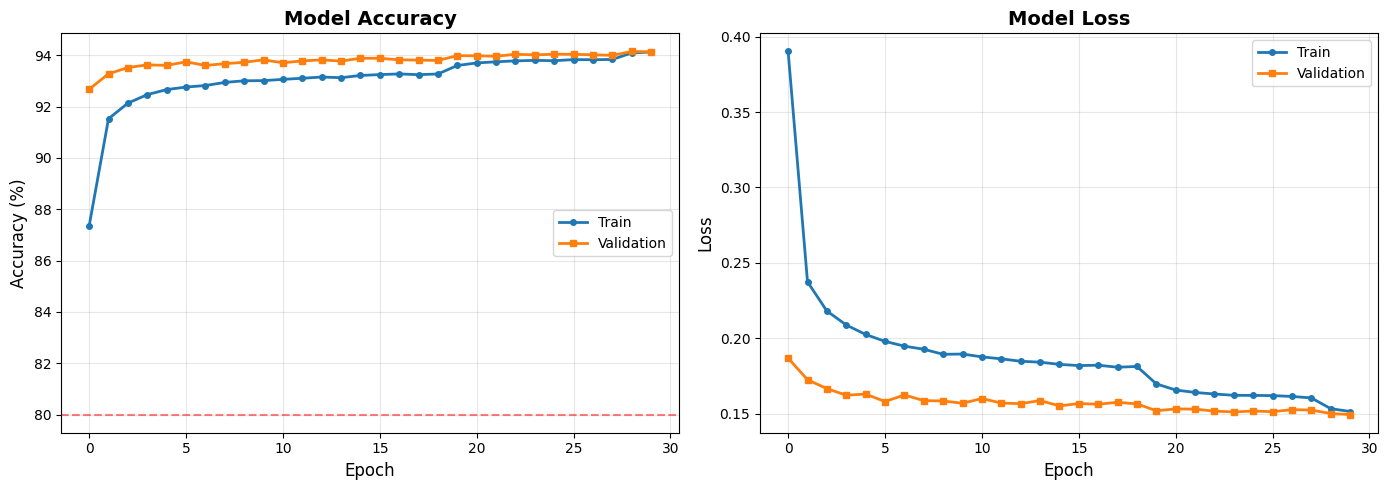

In [10]:
print("\n📈 Generating training visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_acc'], label='Train', linewidth=2, marker='o', markersize=4)
axes[0].plot(history['val_acc'], label='Validation', linewidth=2, marker='s', markersize=4)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=80, color='r', linestyle='--', alpha=0.5)

axes[1].plot(history['train_loss'], label='Train', linewidth=2, marker='o', markersize=4)
axes[1].plot(history['val_loss'], label='Validation', linewidth=2, marker='s', markersize=4)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
print("✅ Saved: training_history.png")
plt.show()



🎯 FINAL EVALUATION


Testing: 100%|██████████| 698/698 [00:20<00:00, 33.55it/s]



🎯 TEST ACCURACY: 94.15%

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0      0.731     0.805     0.766      5778
           1      0.858     0.970     0.910      6330
           2      0.983     0.990     0.987      5869
           3      0.997     0.996     0.997      5969
           4      0.984     0.987     0.985      5619
           5      0.979     0.943     0.961      5190
           6      0.990     0.995     0.992      5705
           7      0.994     0.997     0.995      6139
           8      0.996     0.993     0.994      5633
           9      0.997     0.996     0.997      5686
           A      0.982     0.992     0.987      1062
           B      0.978     0.983     0.981       648
           C      0.982     0.987     0.985      1739
           D      0.937     0.940     0.938       779
           E      0.983     0.994     0.988       851
           F      0.993     0.985     0.989      1440
           G      0.960     0.

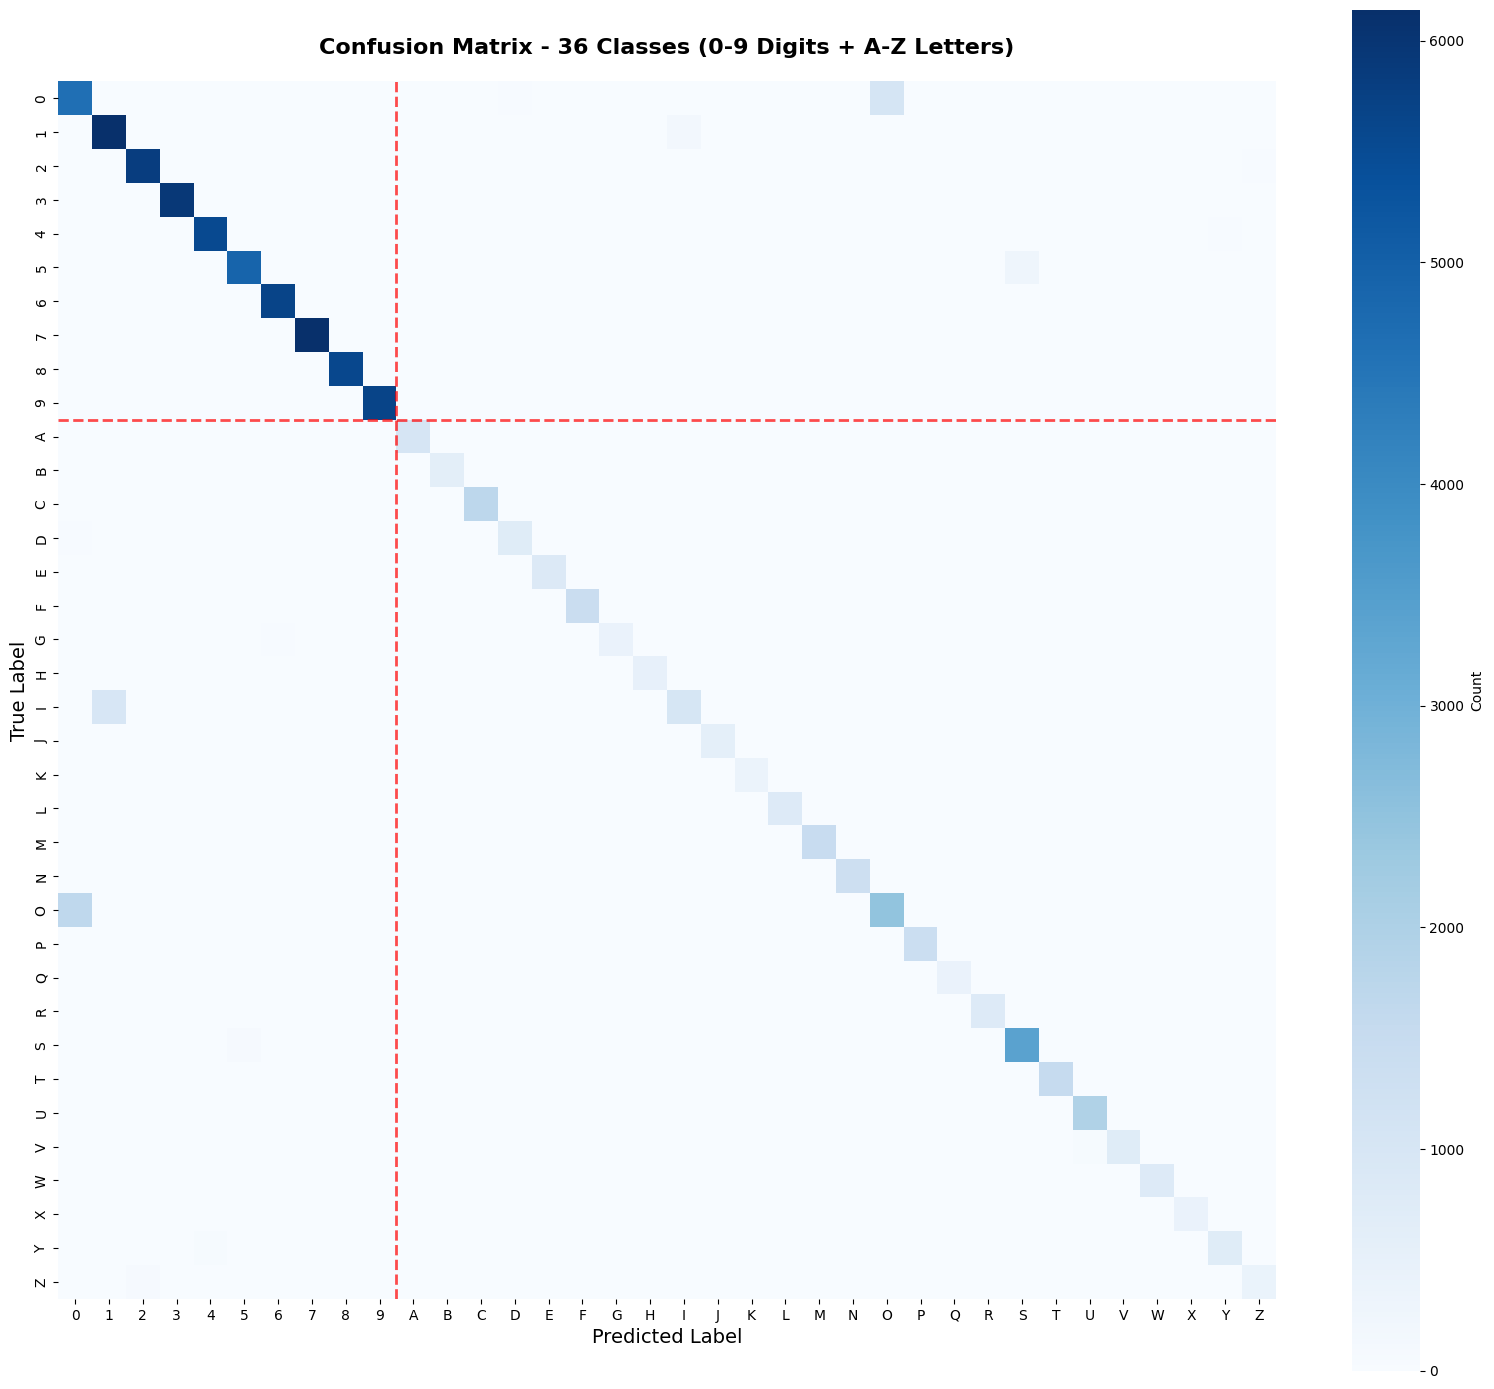

In [28]:
print("\n" + "="*80)
print("🎯 FINAL EVALUATION")
print("="*80)

model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

test_accuracy = accuracy_score(all_labels, all_preds) * 100

print(f"\n{'='*80}")
print(f"🎯 TEST ACCURACY: {test_accuracy:.2f}%")
print(f"{'='*80}")

# Classification report
print(f"\n📋 CLASSIFICATION REPORT:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=3))

# Confusion Matrix
print(f"\n🔢 Generating confusion matrix...")
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, square=True)

plt.title('Confusion Matrix - 36 Classes (0-9 Digits + A-Z Letters)',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)

# Add separation lines
plt.axhline(y=10, color='red', linewidth=2, linestyle='--', alpha=0.7)
plt.axvline(x=10, color='red', linewidth=2, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('confusion_matrix_36classes.png', dpi=300, bbox_inches='tight')
print("✅ Saved: confusion_matrix_36classes.png")
plt.show()


📤 CUSTOM IMAGE PREDICTION
📤 Upload your handwritten digit or letter:
   - Supported: PNG, JPG, JPEG
   - Works with black-on-white or white-on-black



Saving K.png to K (2).png

✅ Uploaded: K (2).png

🔍 Preprocessing image...


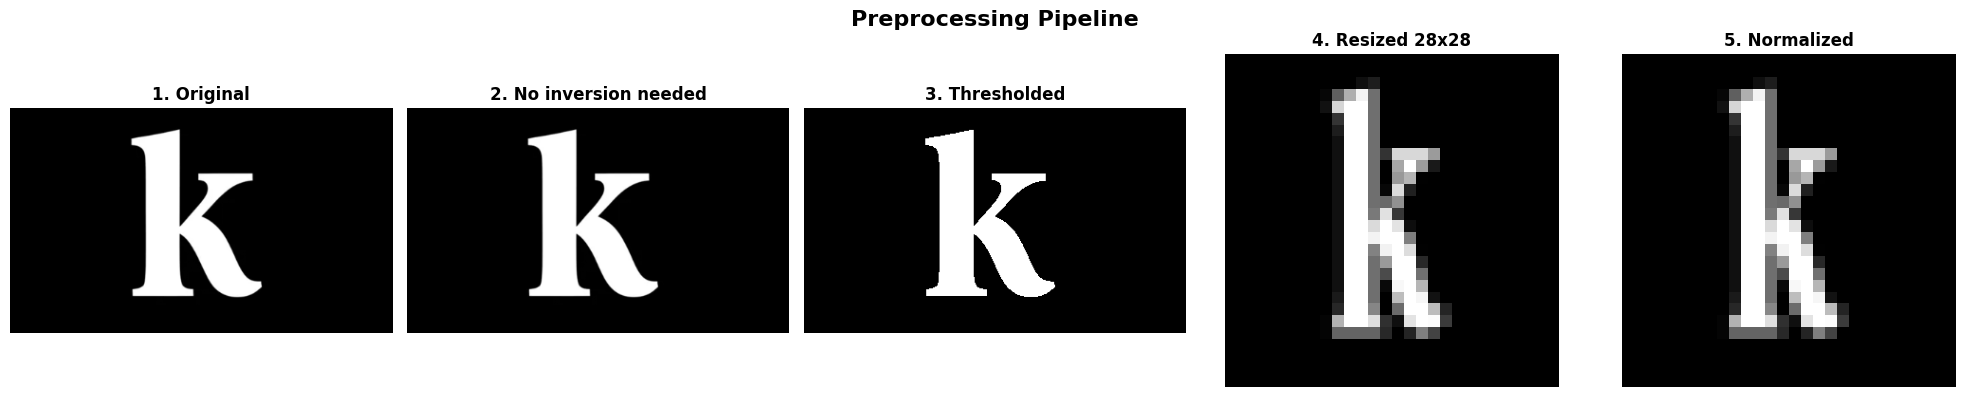


🤖 Making prediction...

🎯 PREDICTION RESULTS
✅ Predicted: K
✅ Confidence: 99.96%
✅ Type: LETTER

📊 Top 5 Predictions:
   1. K: 99.96%
   2. X: 0.02%
   3. R: 0.01%
   4. L: 0.00%
   5. H: 0.00%


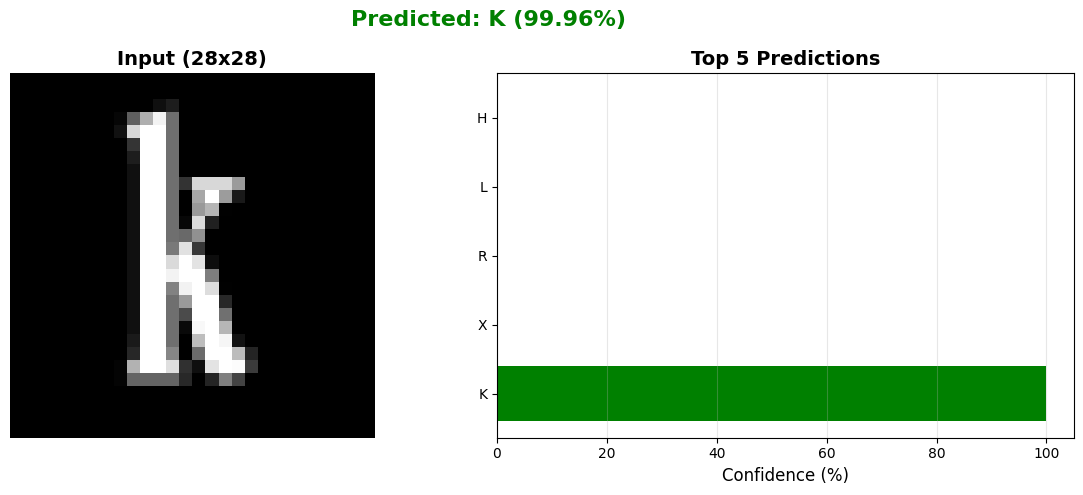


✅ PREDICTION COMPLETE!
   Your character is: K
   Confidence: 99.96%


In [32]:
print("\n" + "="*80)
print("📤 CUSTOM IMAGE PREDICTION")
print("="*80)

from google.colab import files
import cv2

def preprocess_for_prediction(image_path):
    """Preprocess uploaded image"""
    img = Image.open(image_path).convert('L')

    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    # Original
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('1. Original', fontweight='bold')
    axes[0].axis('off')

    img_array = np.array(img)

    # Invert if needed
    if img_array.mean() > 127:
        img_array = 255 - img_array
        axes[1].imshow(img_array, cmap='gray')
        axes[1].set_title('2. Inverted', fontweight='bold')
    else:
        axes[1].imshow(img_array, cmap='gray')
        axes[1].set_title('2. No inversion needed', fontweight='bold')
    axes[1].axis('off')

    # Threshold
    _, img_thresh = cv2.threshold(img_array, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    axes[2].imshow(img_thresh, cmap='gray')
    axes[2].set_title('3. Thresholded', fontweight='bold')
    axes[2].axis('off')

    # Resize to 28x28
    img_resized = cv2.resize(img_thresh, (28, 28), interpolation=cv2.INTER_AREA)
    axes[3].imshow(img_resized, cmap='gray')
    axes[3].set_title('4. Resized 28x28', fontweight='bold')
    axes[3].axis('off')

    # Normalize
    img_normalized = img_resized.astype('float32') / 255.0
    img_normalized = (img_normalized - 0.1307) / 0.3081  # EMNIST normalization
    axes[4].imshow(img_normalized, cmap='gray')
    axes[4].set_title('5. Normalized', fontweight='bold')
    axes[4].axis('off')

    plt.suptitle('Preprocessing Pipeline', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    img_tensor = torch.FloatTensor(img_normalized).unsqueeze(0).unsqueeze(0)
    return img_tensor, img_resized

def predict_image(image_path):
    """Predict character from image"""
    print("🔍 Preprocessing image...")
    img_tensor, final_img = preprocess_for_prediction(image_path)

    print("\n🤖 Making prediction...")
    model.eval()
    with torch.no_grad():
        img_tensor = img_tensor.to(device)
        output = model(img_tensor)
        probs = F.softmax(output, dim=1)
        confidence, predicted = probs.max(1)

    pred_class = predicted.item()
    pred_label = class_names[pred_class]
    pred_confidence = confidence.item() * 100

    # Top 5
    top5_probs, top5_indices = torch.topk(probs, 5)
    top5_probs = top5_probs[0].cpu().numpy() * 100
    top5_indices = top5_indices[0].cpu().numpy()

    print(f"\n{'='*80}")
    print(f"🎯 PREDICTION RESULTS")
    print(f"{'='*80}")
    print(f"✅ Predicted: {pred_label}")
    print(f"✅ Confidence: {pred_confidence:.2f}%")
    print(f"✅ Type: {'DIGIT' if pred_class < 10 else 'LETTER'}")

    print(f"\n📊 Top 5 Predictions:")
    for i, (idx, prob) in enumerate(zip(top5_indices, top5_probs)):
        print(f"   {i+1}. {class_names[idx]}: {prob:.2f}%")

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].imshow(final_img, cmap='gray')
    axes[0].set_title('Input (28x28)', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    axes[1].barh([class_names[i] for i in top5_indices], top5_probs,
                 color=['green' if i == 0 else 'skyblue' for i in range(5)])
    axes[1].set_xlabel('Confidence (%)', fontsize=12)
    axes[1].set_title('Top 5 Predictions', fontsize=14, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)

    plt.suptitle(f'Predicted: {pred_label} ({pred_confidence:.2f}%)',
                 fontsize=16, fontweight='bold', color='green')
    plt.tight_layout()
    plt.show()

    return pred_label, pred_confidence

print("📤 Upload your handwritten digit or letter:")
print("   - Supported: PNG, JPG, JPEG")
print("   - Works with black-on-white or white-on-black\n")

uploaded = files.upload()

if uploaded:
    image_name = list(uploaded.keys())[0]
    print(f"\n✅ Uploaded: {image_name}\n")

    try:
        predicted_char, confidence = predict_image(image_name)
        print(f"\n{'='*80}")
        print(f"✅ PREDICTION COMPLETE!")
        print(f"   Your character is: {predicted_char}")
        print(f"   Confidence: {confidence:.2f}%")
        print(f"{'='*80}")
    except Exception as e:
        print(f"❌ Error: {str(e)}")
else:
    print("❌ No file uploaded")


💾 Saving prediction samples...
✅ Correctly predicted: 84041/89264 (94.15%)
✅ Saved: correct_predictions.png


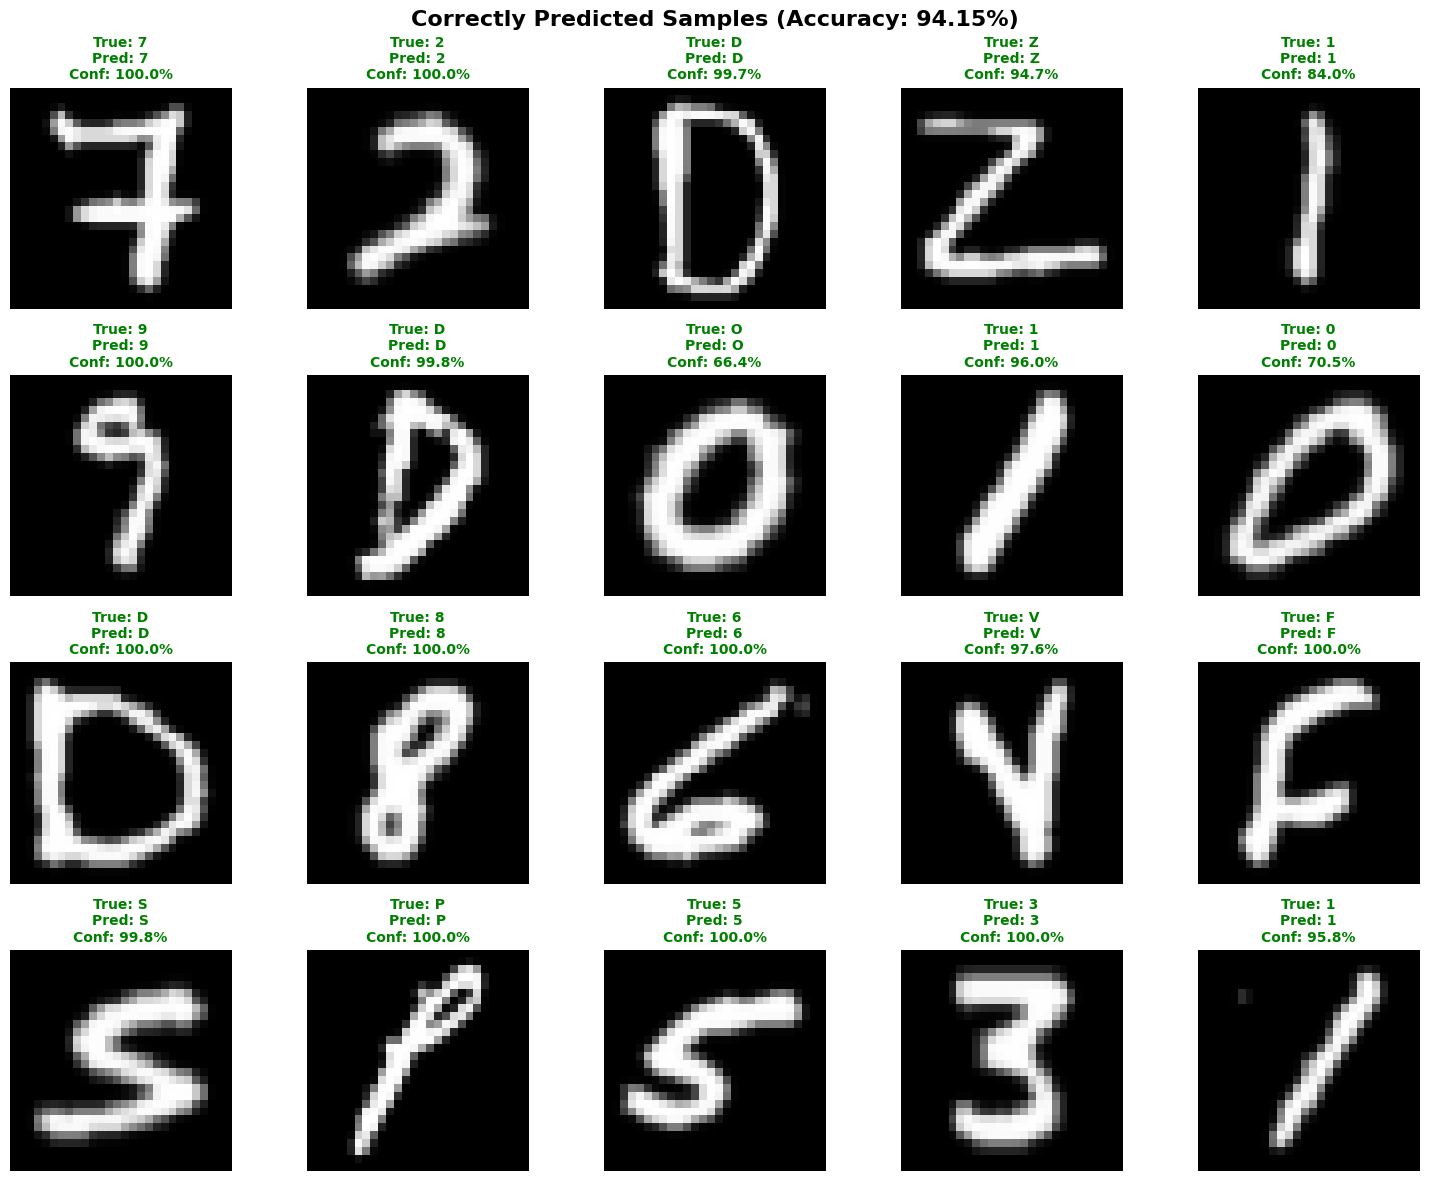

In [33]:
print("\n💾 Saving prediction samples...")

correct_mask = (all_preds == all_labels)
correct_indices = np.where(correct_mask)[0]

print(f"✅ Correctly predicted: {len(correct_indices)}/{len(all_labels)} ({100*len(correct_indices)/len(all_labels):.2f}%)")

# Visualize samples
num_samples = min(20, len(correct_indices))
sample_indices = np.random.choice(correct_indices, num_samples, replace=False)

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.ravel()

for i, test_idx in enumerate(sample_indices):
    # Get original image from test dataset
    original_idx = list(test_dataset.indices)[test_idx]
    img, true_label = test_dataset_full[original_idx]

    pred_label = all_preds[test_idx]
    confidence = all_probs[test_idx][pred_label] * 100

    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {confidence:.1f}%',
                      fontsize=10, color='green', fontweight='bold')

plt.suptitle(f'Correctly Predicted Samples (Accuracy: {test_accuracy:.2f}%)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correct_predictions.png', dpi=300, bbox_inches='tight')
print("✅ Saved: correct_predictions.png")
plt.show()